In [2]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt


import random 
import math

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [3]:
# Block - Data Pre-processing 

csv_data = pd.read_csv('input/CO2_barrier_dataset_radius_feture.csv')
csv_data.info()

train_X, test_X, train_y, test_y = train_test_split(csv_data.Canonical_STRONGs, csv_data.barrier_CO2, test_size = 0.25, random_state = 42)
train_X, train_y = train_X.reset_index(drop=True), train_y.reset_index(drop=True)
test_X, test_y = test_X.reset_index(drop=True), test_y.reset_index(drop=True)

print(train_X[1])
print(train_y[1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20812 entries, 0 to 20811
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         20812 non-null  int64  
 1   pore_number        20812 non-null  int64  
 2   pore_N             20812 non-null  int64  
 3   Canonical_STRONGs  20812 non-null  object 
 4   barrier_CO2        20812 non-null  float64
 5   x_coord            20812 non-null  float64
 6   y_coord            20812 non-null  float64
 7   radius             20812 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 1.3+ MB
243AAFFFSFZFFZFFAAFFFZFZFAAFFFZFZFFZFF
2.39


In [4]:
# Block - Data pre-processing (tokenization)

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words = None, # maximum number of words to keep
    filters="", #find each character after other  
    char_level=True # treat each character as token
)

# updates internal vocabulary based on a list of texts, required before using texts_to_sequences
tokenizer.fit_on_texts(train_X)

In [5]:
# Block - Data pre-processing (padding)

# transforms each text in texts to a sequence of integers, padded to a length of 50
max_len = csv_data.Canonical_STRONGs.map(lambda x: len(x)).max()

train_X = tokenizer.texts_to_sequences(train_X)
padded_train_X = tf.keras.preprocessing.sequence.pad_sequences(train_X, padding="post", maxlen = max_len)
test_X = tokenizer.texts_to_sequences(test_X)
padded_test_X = tf.keras.preprocessing.sequence.pad_sequences(test_X, padding="post", maxlen = max_len)

print(padded_train_X[1])
print(padded_test_X[15])

[4 6 9 3 3 1 1 1 5 1 2 1 1 2 1 1 3 3 1 1 1 2 1 2 1 3 3 1 1 1 2 1 2 1 1 2 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 4 13 12  3  3  1  1  1  2  1  1  3  5  1  2  1  1  2  1  1  2  1  3  3
  1  1  1  2  1  2  1  1  2  1  2  1  1  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]


In [6]:
print(max_len)

51


# Hyperparameter Tuning

In [20]:
# K-Fold Cross validation for hyperparameter tuning
vocab_size = 17

def create_model(embedding_dim, gru_units, dense_units, activation):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True))
    model.add(tf.keras.layers.GRU(gru_units))
    
    for units in dense_units:
        model.add(tf.keras.layers.Dense(units=units, activation=activation))
    
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(loss = tf.losses.MeanSquaredError() , optimizer = tf.optimizers.Adam(), metrics = tf.metrics.MeanAbsoluteError())
    return model

In [21]:
# Parameter Grid to be tuned

param_grid = {
    'embedding_dim':[16, 32, max_len],
    'gru_units': [16, 32, max_len],
    'dense_units':[[max_len,45,40,35,30,25,20,15,10,5],[max_len,42,36,30,24,18,12,6,3],[max_len,32,24,16,8,4]],
    'activation': ['relu'], 
}

In [22]:
# Grid search CV (5 fold)

# create the KerasRegressor warpper with the RNN model function
model = KerasRegressor(build_fn=create_model, verbose=0)

# define the cross-validation strategy (K-fold)
cross_validation = KFold(n_splits=5)

# define the GridSearchCV with the model, hyperparameters, and cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv= cross_validation, scoring='r2') 

C:\Users\91739\AppData\Local\Temp\ipykernel_24204\3396724561.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


In [23]:
grid_search.fit(padded_train_X, train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000001F2393B6880>,
             param_grid={'activation': ['relu'],
                         'dense_units': [[51, 45, 40, 35, 30, 25, 20, 15, 10,
                                          5],
                                         [51, 42, 36, 30, 24, 18, 12, 6, 3],
                                         [51, 32, 24, 16, 8, 4]],
                         'embedding_dim': [16, 32, 51],
                         'gru_units': [16, 32, 51]},
             scoring='r2')

In [24]:
# Print the best hyperparameters and corresponding R2 score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best R2 Score: ", grid_search.best_score_)

Best Hyperparameters:  {'activation': 'relu', 'dense_units': [51, 32, 24, 16, 8, 4], 'embedding_dim': 51, 'gru_units': 51}
Best R2 Score:  0.12295870582505093


# Developed Sequential Model

In [54]:
# Sequential model developed using hyperparameter obtained from k-fold cross validation

vocab_size = 17

model = tf.keras.Sequential()
 
model.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=max_len, mask_zero=True))
model.add(tf.keras.layers.GRU(max_len))
   
# ANN start layer
model.add(tf.keras.layers.Dense(max_len, activation="relu"))
#model.add(tf.keras.layers.Dense(40, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(24, activation="relu"))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(8, activation="relu"))
model.add(tf.keras.layers.Dense(4, activation="relu"))

    
# regression, so no activation
model.add(tf.keras.layers.Dense(1))
    
# compile the model
model.compile(loss = tf.losses.MeanSquaredError(), optimizer = tf.optimizers.Adam(), metrics = tf.metrics.MeanAbsoluteError())
    
# train the model
model_history = model.fit(padded_train_X, train_y, batch_size=32, epochs=200)

Epoch 1/200
488/488 [==============================] - 20s 34ms/step - loss: 60.6766 - mean_absolute_error: 4.0005
Epoch 2/200
488/488 [==============================] - 16s 33ms/step - loss: 28.0358 - mean_absolute_error: 2.0040
Epoch 3/200
488/488 [==============================] - 16s 33ms/step - loss: 28.3573 - mean_absolute_error: 1.9275
Epoch 4/200
488/488 [==============================] - 16s 33ms/step - loss: 17.4150 - mean_absolute_error: 1.5539
Epoch 5/200
488/488 [==============================] - 16s 33ms/step - loss: 13.1775 - mean_absolute_error: 1.3483
Epoch 6/200
488/488 [==============================] - 16s 33ms/step - loss: 11.3331 - mean_absolute_error: 1.2484
Epoch 7/200
488/488 [==============================] - 16s 33ms/step - loss: 9.5175 - mean_absolute_error: 1.1751
Epoch 8/200
488/488 [==============================] - 16s 33ms/step - loss: 10.4416 - mean_absolute_error: 1.2466
Epoch 9/200
488/488 [==============================] - 16s 33ms/step - loss: 7.30

488/488 [==============================] - 15s 31ms/step - loss: 1.8084 - mean_absolute_error: 0.5993
Epoch 73/200
488/488 [==============================] - 15s 31ms/step - loss: 1.6599 - mean_absolute_error: 0.5879
Epoch 74/200
488/488 [==============================] - 15s 31ms/step - loss: 1.6167 - mean_absolute_error: 0.5847
Epoch 75/200
488/488 [==============================] - 15s 31ms/step - loss: 1.6304 - mean_absolute_error: 0.5816
Epoch 76/200
488/488 [==============================] - 15s 31ms/step - loss: 1.5906 - mean_absolute_error: 0.5797
Epoch 77/200
488/488 [==============================] - 15s 32ms/step - loss: 1.5405 - mean_absolute_error: 0.5709
Epoch 78/200
488/488 [==============================] - 15s 31ms/step - loss: 1.4500 - mean_absolute_error: 0.5600
Epoch 79/200
488/488 [==============================] - 15s 31ms/step - loss: 1.5034 - mean_absolute_error: 0.5661
Epoch 80/200
488/488 [==============================] - 15s 31ms/step - loss: 1.5175 - mean_a

Epoch 143/200
488/488 [==============================] - 16s 32ms/step - loss: 0.5223 - mean_absolute_error: 0.3908
Epoch 144/200
488/488 [==============================] - 16s 32ms/step - loss: 0.4133 - mean_absolute_error: 0.3661
Epoch 145/200
488/488 [==============================] - 17s 34ms/step - loss: 0.4516 - mean_absolute_error: 0.3747
Epoch 146/200
488/488 [==============================] - 16s 32ms/step - loss: 0.5875 - mean_absolute_error: 0.4049
Epoch 147/200
488/488 [==============================] - 16s 32ms/step - loss: 0.4742 - mean_absolute_error: 0.3808
Epoch 148/200
488/488 [==============================] - 16s 32ms/step - loss: 0.4242 - mean_absolute_error: 0.3680
Epoch 149/200
488/488 [==============================] - 18s 36ms/step - loss: 0.5310 - mean_absolute_error: 0.3898
Epoch 150/200
488/488 [==============================] - 17s 34ms/step - loss: 0.5457 - mean_absolute_error: 0.3981
Epoch 151/200
488/488 [==============================] - 17s 34ms/step -

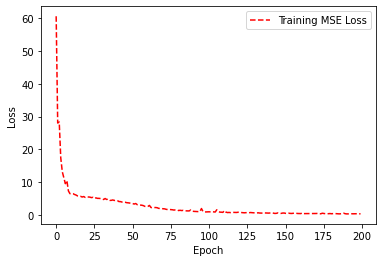

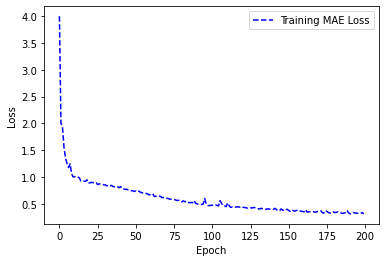

In [55]:
# plotting mse loss
training_mse_loss = model_history.history['loss']
training_mae_loss = model_history.history['mean_absolute_error']

epoch_count = range(0,len(training_mse_loss))

plt.plot(epoch_count, training_mse_loss[0:], 'r--')
plt.legend(['Training MSE Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

plt.plot(epoch_count, training_mae_loss[0:], 'b--')
plt.legend(['Training MAE Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [56]:
# evaluate on test data
yhat = model.predict(padded_test_X)

# evaluate on train data
yhat_train = model.predict(padded_train_X)

488/488 [==============================] - 5s 10ms/step


test metrics
0.6144173225237501
3.5460919774483846
0.9396509253418248
train metrics
0.2881207465621432
0.22155676026963916
0.9963563274728432


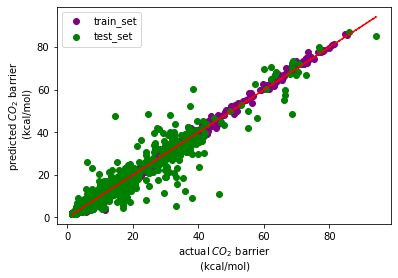

In [57]:
print("test metrics")
mae_test = metrics.mean_absolute_error(test_y,yhat)
mse_test = metrics.mean_squared_error(test_y,yhat)
r2_test = metrics.r2_score(test_y,yhat)

print(mae_test)
print(mse_test)
print(r2_test)

print("train metrics")
mae_train = metrics.mean_absolute_error(train_y,yhat_train)
mse_train = metrics.mean_squared_error(train_y,yhat_train)
r2_train = metrics.r2_score(train_y,yhat_train)

print(mae_train)
print(mse_train)
print(r2_train)

plt.scatter(train_y,yhat_train,color = 'purple')
plt.scatter(test_y,yhat, color = 'green')
plt.plot(test_y,test_y, 'r--')
#plt.title('Parity plot')
plt.ylabel('predicted $CO_{2}$ barrier \n (kcal/mol)')
plt.xlabel('actual $CO_{2}$ barrier \n (kcal/mol)')
plt.legend(['train_set', 'test_set'])
plt.show()

# Saving the trained model

In [58]:
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

In [59]:
# save the model to disk
filename = 'output/CO2_barrier_1/CO2_barrier_model.h5'
save_model(model, filename)

# Loading the saved model

In [60]:
# load the model from disk
filename = 'output/CO2_barrier_1/CO2_barrier_model.h5'
loaded_model = load_model(filename)

# Testing the saved model

In [61]:
# evaluate on train and test data
yhat_test_loaded = loaded_model.predict(padded_test_X)
yhat_train_loaded = loaded_model.predict(padded_train_X)

488/488 [==============================] - 5s 10ms/step


In [62]:
print("test metrics")
mae_test = metrics.mean_absolute_error(test_y,yhat_test_loaded)
mse_test = metrics.mean_squared_error(test_y,yhat_test_loaded)
r2_test = metrics.r2_score(test_y,yhat_test_loaded)

print(mae_test)
print(mse_test)
print(r2_test)

print("train metrics")
mae_train = metrics.mean_absolute_error(train_y,yhat_train_loaded)
mse_train = metrics.mean_squared_error(train_y,yhat_train_loaded)
r2_train = metrics.r2_score(train_y,yhat_train_loaded)

print(mae_train)
print(mse_train)
print(r2_train)

test metrics
0.6144173225237501
3.5460919774483846
0.9396509253418248
train metrics
0.2881207465621432
0.22155676026963916
0.9963563274728432


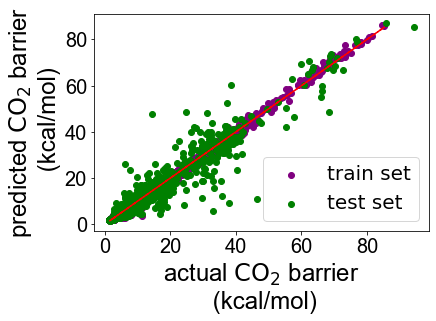

In [63]:
plt.scatter(train_y,yhat_train_loaded,color = 'purple')
plt.scatter(test_y,yhat_test_loaded, color = 'green')
plt.plot(train_y,train_y, 'r--')

plt.ylabel('predicted $\\rm CO_{2}$ barrier \n (kcal/mol)', fontname="Arial", fontsize=24)
plt.xlabel('actual $\\rm CO_{2}$ barrier \n (kcal/mol)', fontname="Arial", fontsize=24)
plt.legend(['train set', 'test set'], fontsize="20" )
plt.xticks(fontsize=20, fontname="Arial")
plt.yticks(fontsize=20, fontname="Arial")
plt.savefig("figures/CO2_barrier_1/parity_plot.png", format="png", dpi=1600, bbox_inches='tight')
plt.show()

# Predicting CO2 Barriers for stable nanopores obtained using STRONGs algorithm

In [64]:
# Feature Data - Canonical STRONGs for stable nanopores

csv_data_stable_nanopores = pd.read_csv('input/stable_nanopores_data_radius_feature.csv')
csv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20812 entries, 0 to 20811
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         20812 non-null  int64  
 1   pore_number        20812 non-null  int64  
 2   pore_N             20812 non-null  int64  
 3   Canonical_STRONGs  20812 non-null  object 
 4   barrier_CO2        20812 non-null  float64
 5   x_coord            20812 non-null  float64
 6   y_coord            20812 non-null  float64
 7   radius             20812 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 1.3+ MB


In [65]:
# Tokenization of Feature Data

stable_nanopores_STRONG_X = tokenizer.texts_to_sequences(csv_data_stable_nanopores['Canonical_STRONGs'])
stable_nanopores_padded_X = tf.keras.preprocessing.sequence.pad_sequences(stable_nanopores_STRONG_X, padding="post", maxlen = max_len)

In [66]:
# Calculating CO2 barriers for stable nanopores
stable_nanopores_yhat = loaded_model.predict(stable_nanopores_padded_X)

12739/12739 [==============================] - 139s 11ms/step


In [67]:
# saving the CO2 barrier for stable nanopores
type(stable_nanopores_yhat)
np.savetxt('input/stable_strong_barrier_CO2.csv', stable_nanopores_yhat)